# CIRCUIT LAYOUT

In [1]:
import fastf1 as ff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fastf1.plotting
fastf1.plotting.setup_mpl()
import fastf1.api as fap
import re
import datetime as dt
import fastf1.mvapi as famp
import fastf1.events as fae
from matplotlib.collections import LineCollection
import matplotlib as mpl


d:\Prabhu\SEM 7\F1 Data\.venv\Lib\site-packages\fastf1\api.py:32: UserWarning: `fastf1.api` will be considered private in future releases and potentially be removed or changed!
  warnings.warn("`fastf1.api` will be considered private in future releases and "


In [2]:
session = ff.get_session(2023,'Dutch','R')
session.load()
session_start_time=session.t0_date

req         WARNING 	DEFAULT CACHE ENABLED! (639.09 MB) C:\Users\prabh\AppData\Local\Temp\fastf1


core           INFO 	Loading data for Dutch Grand Prix - Race [v3.3.7]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '14', '10', '11', '55', '44', '4', '23', '81', '31', '18', '27', '40', '77', '22', '20', '63', '24', '16', '2']


In [3]:
weekend = session.event.EventName
circuit_info=session.get_circuit_info()
corners_data=circuit_info.corners

In [4]:
lap = session.laps.pick_fastest()
# Get telemetry data
x = lap.telemetry['X']              # values for x-axis
y = lap.telemetry['Y']              # values for y-axis
color = lap.telemetry['Speed'] 

In [5]:
lap = session.laps.pick_fastest()
pos = lap.get_pos_data()

In [6]:
def rotate(xy, *, angle):
    rot_mat = np.array([[np.cos(angle), np.sin(angle)],
                        [-np.sin(angle), np.cos(angle)]])
    return np.matmul(xy, rot_mat)

In [7]:
# Get an array of shape [n, 2] where n is the number of points and the second
# axis is x and y.
track = pos.loc[:, ('X', 'Y')].to_numpy()

# Convert the rotation angle from degrees to radian.
track_angle = circuit_info.rotation / 180 * np.pi

# Rotate and plot the track map.
rotated_track = rotate(track, angle=track_angle)

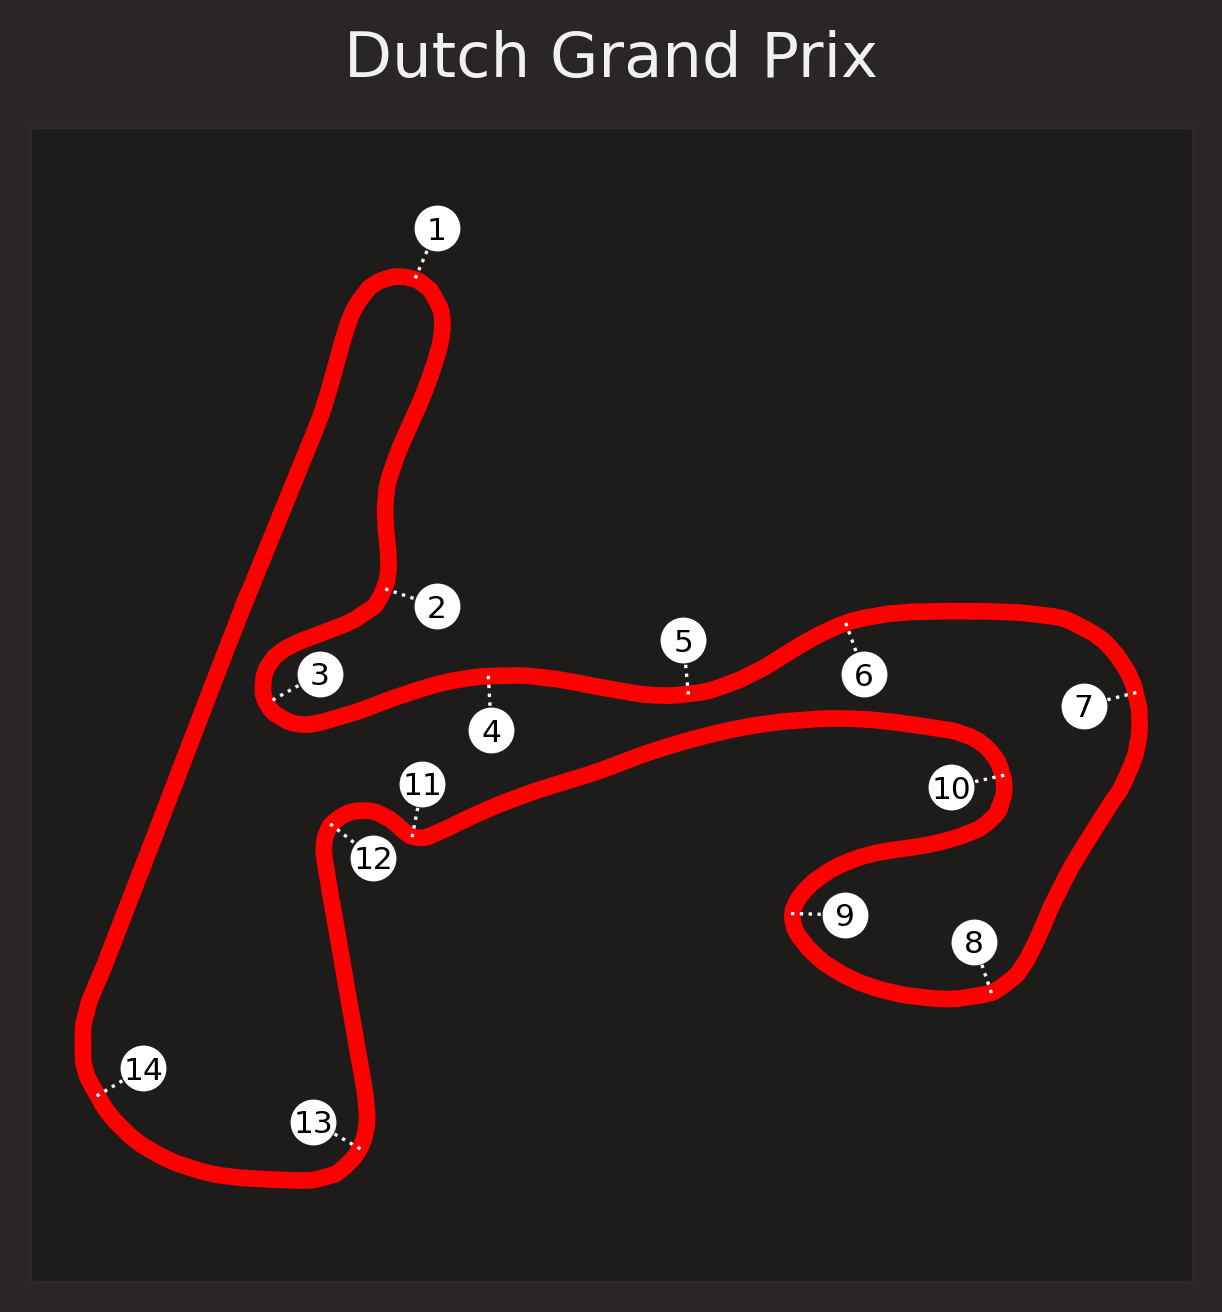

In [8]:
plt.figure(figsize=(5, 5),dpi=300)

offset_vector = [500, 0]  # offset length is chosen arbitrarily to 'look good'

# Iterate over all corners.
for _, corner in circuit_info.corners.iterrows():
    # Create a string from corner number and letter
    txt = f"{corner['Number']}{corner['Letter']}"

    # Convert the angle from degrees to radian.
    offset_angle = corner['Angle'] / 180 * np.pi

    # Rotate the offset vector so that it points sideways from the track.
    offset_x, offset_y = rotate(offset_vector, angle=offset_angle)

    # Add the offset to the position of the corner
    text_x = corner['X'] + offset_x
    text_y = corner['Y'] + offset_y

    # Rotate the text position equivalently to the rest of the track map
    text_x, text_y = rotate([text_x, text_y], angle=track_angle)

    # Rotate the center of the corner equivalently to the rest of the track map
    track_x, track_y = rotate([corner['X'], corner['Y']], angle=track_angle)

    # Draw a circle next to the track.
    plt.scatter(text_x, text_y, color='white', s=100)

    # Draw a line from the track to this circle.
    plt.plot([track_x, text_x], [track_y, text_y], lw=0.8, linestyle='dotted', color='white')

    # Finally, print the corner number inside the circle.
    plt.text(text_x, text_y, txt, va='center_baseline', ha='center', size='7.5', color='black')

plt.plot(lap.telemetry['X'], lap.telemetry['Y'], color='red', linestyle='-', linewidth=4, zorder=0)

plt.title(session.event['EventName'],fontsize=15)
plt.xticks([])
plt.yticks([])
plt.axis('equal')
plt.show()

In [9]:
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

In [10]:
track = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
colormap = 'turbo'

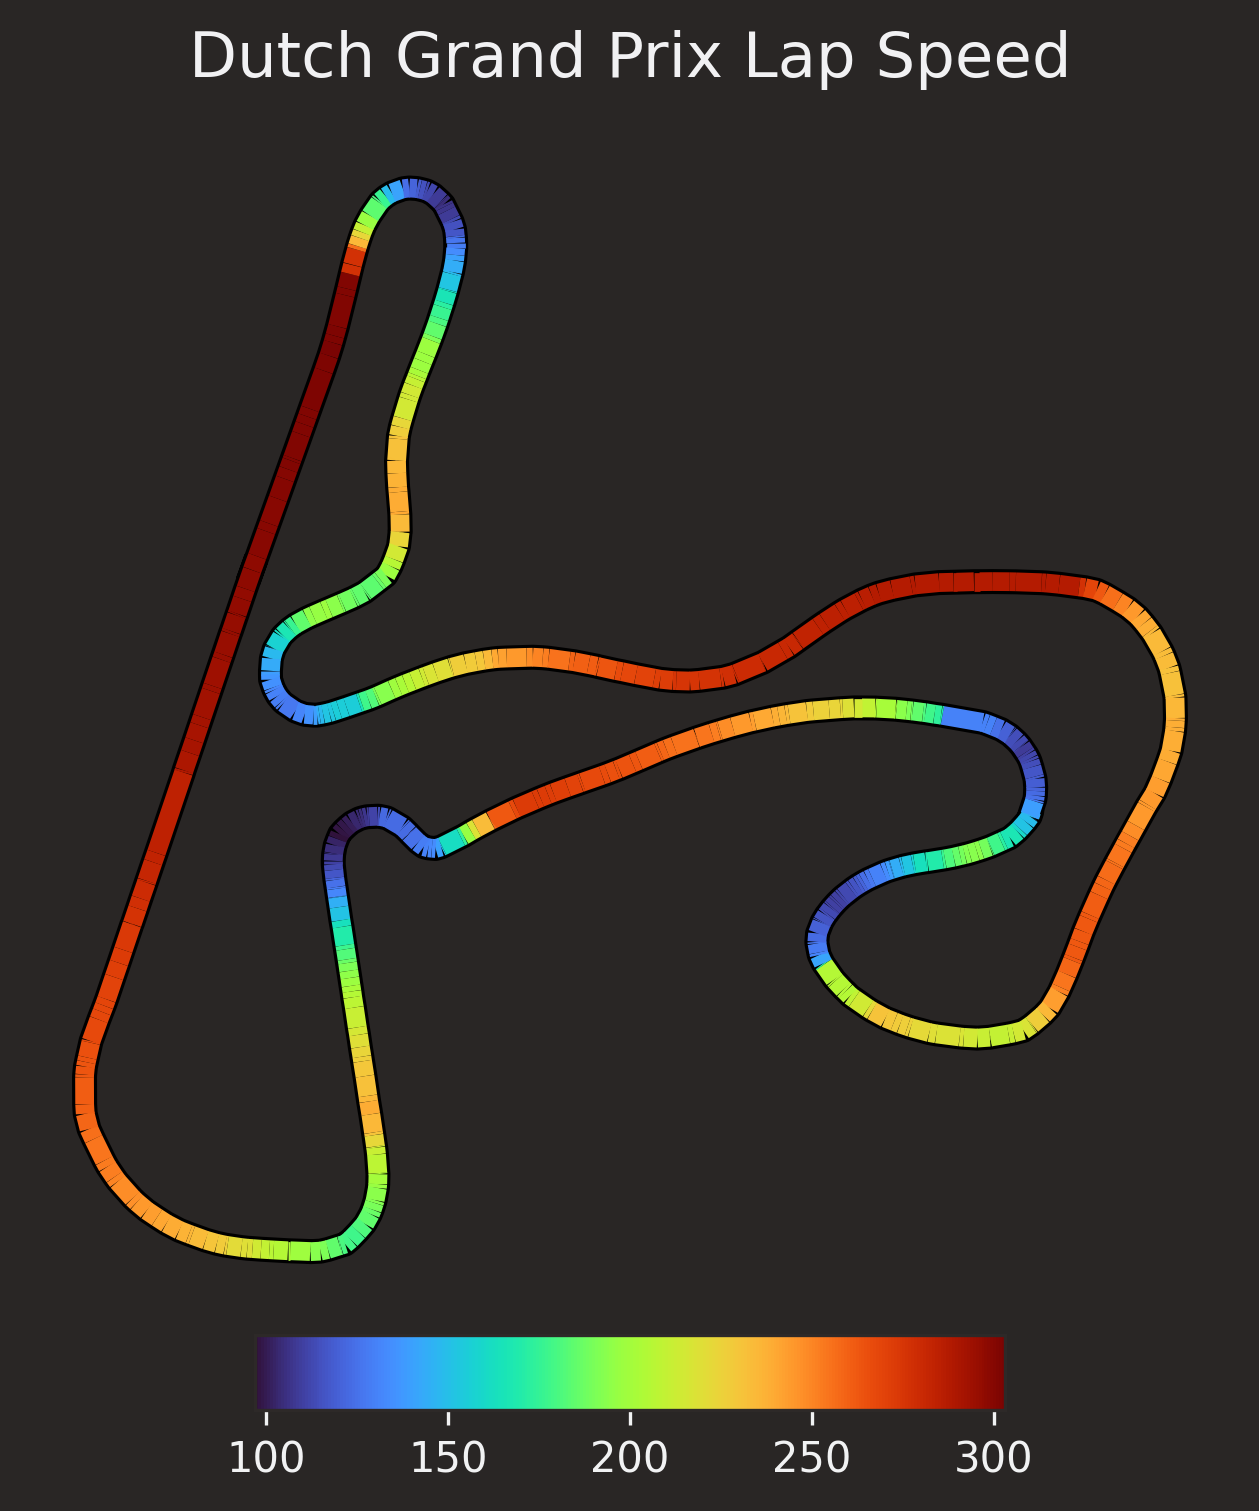

In [11]:
# We create a plot with title and adjust some setting to make it look good.
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(5, 5),dpi=300)
fig.suptitle(session.event['EventName']+' Lap Speed', size=15, y=0.97)

# Adjust margins and turn of axis
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.12)
ax.axis('off')


# After this, we plot the data itself.
# Create background track line
ax.plot(lap.telemetry['X'], lap.telemetry['Y'], color='black', linestyle='-', linewidth=6, zorder=0)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(color.min(), color.max())
lc = LineCollection(segments, cmap=colormap, norm=norm, linestyle='-', linewidth=4.5)

# Set the values used for colormapping
lc.set_array(color)

# Merge all line segments together
line = ax.add_collection(lc)


# Finally, we create a color bar as a legend.
cbaxes = fig.add_axes([0.25, 0.05, 0.5, 0.05])
normlegend = mpl.colors.Normalize(vmin=color.min(), vmax=color.max())
legend = mpl.colorbar.ColorbarBase(cbaxes, norm=normlegend, cmap=colormap, orientation="horizontal")


# Show the plot
plt.show()